# Causation (Chain of Thoughts Self Consistency)

Chain of Thoughts is a prompting technique that use examples containing steps to assist with the reasoning ability of a large language model (llm).

Self consistency is a layer that adds on top that leverage the probabilistic outputs from LLMs and take the majority vote as the final answer.

This notebook is an implementation of this for the GEF causation project.

## Paper: Chain of Thoughts (expand to read)
Chain of Thought (CoT): https://arxiv.org/abs/2201.11903<br>
CoT Self Consistency (CoT-SC): https://arxiv.org/abs/2203.11171

In [1]:
from IPython.display import IFrame
display(IFrame(src='https://arxiv.org/pdf/2201.11903.pdf', width=1600, height=700))

In [2]:
from IPython.display import IFrame
# CoT - Self Consistency
display(IFrame(src='https://arxiv.org/pdf/2203.11171.pdf', width=1600, height=700))

## Overview
1. Supply your OpenAI API Key
2. Choose a sampling scheme and number of completions
3. Upload your file with the Chain of Thoughts examples.
4. Enter a query (i.e. the sentence) and run it for a classification.

## 1. Enter your Open API Key.
Replace `<OPENAI_API_KEY>` below and retain the double quotes.

In [17]:
OPENAI_API_KEY = "<OPENAI_API_KEY>"

# ignore this: it just sets your key onto the environment variable (disappears after you close it or restart the notebook)
import os
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

## 2. Choose a sampling scheme and the number of completions.

__Sampling Scheme__:
+ `top_p` - **the range of output words within a probability threshold.** (0 < top_p <= 1.0)<br>
e.g. <br>
= 0.3 means sample only from outputs that make up the top 30% of the probabilities.

+ `temperature` - **the higher the temperature the more spread out the probabilities are across the output words.** (0 <= temperature <= 2) <br>
e.g. <br>
= 0 means output probabilities are *not* spread out i.e. Only 1 output token have a probability of 1.0 when the LLM is generating the output. This means it will always choose the same output during the decoding ending up with the same completion.<br>
\> 0, ~0 means output probabilities are a little spread out i.e. > 1 output tokens will have a probability of closer to 1.0, combining to 1.0. This means that the LLM will have a chance of sampling different output tokens.<br>
= 2 means output probabilities are *most* spread out i.e. output tokens will have similar probabilities and the LLM will have similar chance of sampling from each token.

`top_p` and `temperature` goes hand in hand. Having a really low temperature means there are less output tokens within the probability threshold.

__Number of completions__ (relates to: self-consistency):
+ `n_completions` - **this is the number of responses you're asking the LLM to generate.**<br>(increases cost but directly relates to the number of votes used by Self Consistency)

<br>
👼 Experiment with different sampling schemes and increase number of completions for more confidence in your votes (beware of costs!)

In [18]:
from llm_experiments import SamplingScheme

sampling_scheme = SamplingScheme(top_k=None, top_p=0.2, temperature=1)    # top_k is None because OpenAI does not support it.
n_completions = 3

## 3. Upload your Chain of Thoughts examples

Chain of thoughts uses examples to help the LLM reason about your queries better by breaking it down into steps.

The idea is to give it more context and prompt it to break down its reasoning process into steps.

👼 Experiment with different 'steps' for each example, I would recommend having a diverse set of reasons and be specific. <br> 
👼 It's usually better with more examples but this also means it'll increase your API cost (see TikDollar later). Starting out with 3-5 examples per class should be sufficient.

In [19]:
from tempfile import mkdtemp
from pathlib import Path
import panel as pn
pn.extension()

MARKDOWN = str

uploader_data = dict(saved_path=None)

def cb_save_to_file(fbytes: bytes, fname: str) -> MARKDOWN:
    if fbytes is None or len(fbytes) <= 0 or fname is None: return ""
    dir_ = Path(mkdtemp())
    path = dir_.joinpath(fname)
    with open(path, 'wb') as h:
        h.write(finput.value)
    uploader_data['saved_path'] = path
    return f"Received: **{fname}**\t\tSaved temporarily to **{uploader_data.get('saved_path')}**"

finput = pn.widgets.FileInput(accept='.toml')
iobject = pn.bind(cb_save_to_file, finput, finput.param.filename)
pn.Row(finput, pn.pane.Markdown(iobject))

Row
    [0] FileInput(accept='.toml')
    [1] Markdown(str)

In [22]:
from llm_experiments import CoTSC

assert uploader_data.get('saved_path'), "Have you uploaded your Chain of Thoughts examples .toml configuration file?"

cotsc = CoTSC.from_toml(model='text-davinci-003', 
                        prompt_toml=uploader_data.get('saved_path'),
                        sampling_scheme=sampling_scheme, 
                        n_completions=n_completions)

🧑‍💻 Side Note: TOML is a modern standard used often to define configurations in a file for programs. It works well with python and is generally considered to supercede the YAML standard.

### Here's an example

In [23]:
results = cotsc.run(query="Canberra immunologist Carola Vinuesa who discovered a gene responsible for the autoimmune diseases lupus and diabetes.")
results  # raw output

{'specific_aetiology': {'votes': 3,
  'steps': {"discovered a gene responsible for the autoimmune diseases lupus and diabetes, implies genes are responsible, you can't beat it."},
  'completions': ['\nAnswer: {"answer": "specific_aetiology", "steps": "discovered a gene responsible for the autoimmune diseases lupus and diabetes, implies genes are responsible, you can\'t beat it.", "completion": "complete"}',
   '\nAnswer: {"answer": "specific_aetiology", "steps": "discovered a gene responsible for the autoimmune diseases lupus and diabetes, implies genes are responsible, you can\'t beat it.", "completion": "complete"}',
   '\nAnswer: {"answer": "specific_aetiology", "steps": "discovered a gene responsible for the autoimmune diseases lupus and diabetes, implies genes are responsible, you can\'t beat it.", "completion": "complete"}']}}

We'll format the raw output a little bit by putting it in a table.

In [25]:
import pandas as pd
pd.set_option('display.max_colwidth', 250)

pd.DataFrame.from_dict(results, orient='index')

,votes,steps,completions
specific_aetiology,3,"{discovered a gene responsible for the autoimmune diseases lupus and diabetes, implies genes are responsible, you can't beat it.}","[\nAnswer: {""answer"": ""specific_aetiology"", ""steps"": ""discovered a gene responsible for the autoimmune diseases lupus and diabetes, implies genes are responsible, you can't beat it."", ""completion"": ""complete""}, \nAnswer: {""answer"": ""specific_aeti..."


### TikDollar
**Tikdollar is created by SIH to track your OpenAI expense and cut if off at a specified threshold.<br>
The code will run your calls right up until when your next call will exceed this threshold.**

> OpenAI charges for both your input and output tokens. Each token can be thought of as a word in the normal sense but tokens for LLMs are actually *subwords*.

For more information on subwords here's a cool video: https://www.youtube.com/watch?v=zHvTiHr506c

**Now, we're going to bind TikDollar with our CoTSC calling function.**

The parameters you need to care about:
+ `cost_threshold`  - this is the cut-off USD. You'll need to define this. (e.g. 0.1, 1.0, 20)
+ `raise_err` - when the cut-off will be exceeded in the next call, stop. (or print a message then continue if it's False)
+ `verbose` - whether to print messages per call in terms of your spending.

In [31]:
from llm_experiments.utils import TikDollar as td

# ⚠️ Caveat: When you rerun this cell, tikdollar is reset to 0!
tikdollar = td.track(cotsc, cotsc._tikdollar_run, cost_threshold=0.1, raise_err=True, verbose=True)
tikdollar

TikDollar(num_input_tokens=0, num_output_tokens=0, cost=0)

In [32]:
cotsc.run(query="Professor Lawford says the institute, based at the Greenslopes Private Hospital, in Brisbane's south, in conjunction with overseas collaborators, is analysing the DNA of Australian Vietnam veterans in a bid to better understand the causes of PTSD.")

Estimated cost on next request:          Input = 1525 tokens	Output = 192 tokens	$0.03434000	Accumulates to: $0.03434000
Actual cost after request:               Input = 1525 tokens	Output = 132 tokens	Cost=$0.03314


{'not_biased': {'votes': 3,
  'steps': {'This query does not refer to any of the 5 biases.'},
  'completions': ['\n\nAnswer: {\n  "answer": "not_biased",\n  "steps": "This query does not refer to any of the 5 biases.",\n  "completion": "complete"\n}',
   '\n\nAnswer: {\n  "answer": "not_biased",\n  "steps": "This query does not refer to any of the 5 biases.",\n  "completion": "complete"\n}',
   '\n\nAnswer: {\n  "answer": "not_biased",\n  "steps": "This query does not refer to any of the 5 biases.",\n  "completion": "complete"\n}']}}

In [33]:
tikdollar

TikDollar(num_input_tokens=1525, num_output_tokens=132, cost=0.03314)

## Classification

Now that you have **CoTSC** and **TikDollar** you're equipped to run a classification task on your list of sentences!

At the end of this there'll be a link for you to click on to download all the generated results into an excel sheet.

#### 1. Upload your dataset (requires: 'sentence' column)

In [34]:
uploader_data.clear()
finput = pn.widgets.FileInput(accept='.xlsx')
iobject = pn.bind(cb_save_to_file, finput, finput.param.filename)
pn.Row(finput, pn.pane.Markdown(iobject))

Row
    [0] FileInput(accept='.xlsx')
    [1] Markdown(str)

In [47]:
import pandas as pd
assert uploader_data.get('saved_path'), "Did you upload your dataset?"
df = pd.read_excel(uploader_data.get('saved_path'))
df.head(1)

,document,sent_start,gene,before_sent,sentence,after_sent,sent_with_context,det_k,se_k,nat_k,...,se_r,nat_r,hom_r,det,se,nat,hom,pos,sg_notes,count
0,SM110212448,377,gene,"But balding at age 30 or 40 had no impact on the chance of developing prostate cancer, the study found. Researchers suggested an anti-balding pill, finasteride, could be used as a preventative anti-cancer treatment. Of mice and men Research on ra...",The key stem gene Oct4 was still expressed at strong levels.,"""Mice are the universal mammalian embryological model system on which most of our knowledge is based and we tacitly assume we can apply this knowledge to humans and livestock,"" one of the study's author's, Peter Pfeffer, says. ""We were therefore ...","But balding at age 30 or 40 had no impact on the chance of developing prostate cancer, the study found. Researchers suggested an anti-balding pill, finasteride, could be used as a preventative anti-cancer treatment. Of mice and men Research on ra...",0,0,0,...,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN


array([[<Axes: title={'center': 'det'}>, <Axes: title={'center': 'se'}>],
       [<Axes: title={'center': 'nat'}>, <Axes: title={'center': 'hom'}>]],
      dtype=object)

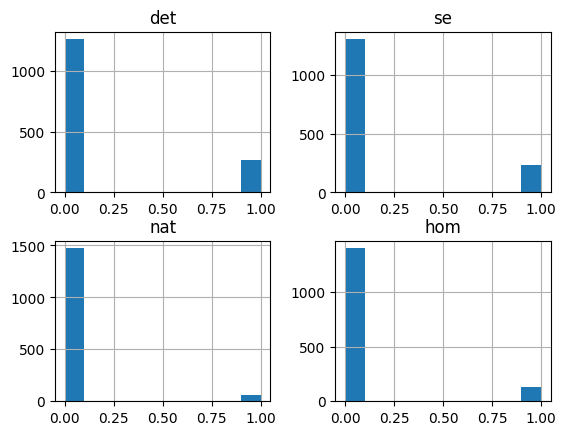

In [49]:
df[['det', 'se', 'nat', 'hom']].hist()

In [50]:
len(df)

1531

#### 2. Set up TikDollar

In [36]:
# Setup TikDollar
# copy of prior cell for task separation and easy access.
from llm_experiments.utils import TikDollar as td

# ⚠️ Caveat: When you rerun this cell, tikdollar is reset to 0!
tikdollar = td.track(cotsc, cotsc._tikdollar_run, cost_threshold=5, raise_err=True, verbose=True)
tikdollar

TikDollar(num_input_tokens=0, num_output_tokens=0, cost=0)

#### 3. Run classification on uploaded dataset

In [ ]:
from llm_experiments.utils.tikdollar import CostThresholdReachedException
from collections import namedtuple
ROW = namedtuple('ROW', ['query', 'clazz', 'votes', 'steps', 'determinism', 'specific_aetiology', 'naturalness', 'homogeneity', 'is_biased', 'completions'])

Rows = list()
for i, row in enumerate(df.sample(10).itertuples()):
    query = row.sentence
    det, se, nat, hom, pos = row.det, row.se, row.nat, row.hom, row.pos
    try:
        results = cotsc.run(query=query)
        for clazz, clz_res in results.items():
            Row = ROW(query=query, clazz=clazz, votes=clz_res.get('votes'), steps=clz_res.get('steps'), 
                      determinism=det, specific_aetiology=se, naturalness=nat, homogeneity=hom, is_biased=pos, completions=clz_res.get('completions'))
            Rows.append(Row)
    except CostThresholdReachedException as ctre:
        print(ctre)
        print(f"Number of queries sent: {i}.")
        break
              
results_df = pd.DataFrame(Rows)

In [40]:
results_df = pd.DataFrame(Rows)

#### 4. Analyse classification results

In [41]:
results_df.head(1)

,query,clazz,votes,steps,determinism,specific_aetiology,naturalness,homogeneity,is_biased,completions
0,Genetic engineering was supposed to provide an alternative to toxic chemicals.,not_biased,3,{This query does not refer to any of the 5 classes.},0,0,1,0,1,"[\nAnswer: {\n ""answer"": ""not_biased"",\n ""steps"": ""This query does not refer to any of the 5 classes."",\n ""completion"": ""complete""\n}, \nAnswer: {\n ""answer"": ""not_biased"",\n ""steps"": ""This query does not refer to any of the 5 classes."",\n ..."


In [42]:
import sys
import numpy as np

clazz_to_idx = {
    "determinism": 0,
    "specific_aetiology": 1,
    "naturalness": 2,
    "homogeneity": 3,
}

def clazz_to_row(clazz: str) -> list[int]:
    # clean up llm output
    try:
        comma_idx = clazz.index(',')
        clazz = clazz[:comma_idx]
    except:
        pass
    clazz = clazz.strip()
    row = [0, 0, 0, 0]
    if clazz == 'not_biased': 
        return row
    elif clazz_to_idx.get(clazz, None) is None:
        print(f"{clazz} is not one of {', '.join(clazz_to_idx.keys())}. Continued as 'not_biased'", file=sys.stderr)
        return row
    else:
        row[clazz_to_idx.get(clazz)] = 1
        return row

preds, targets = list(), list()
for query, group in results_df.groupby(by='query'):
    best_idx = group.loc[:, 'votes'].idxmax()
    best = group.loc[best_idx]
    prediction = clazz_to_row(best.clazz)
    target = group[['determinism', 'specific_aetiology', 'naturalness', 'homogeneity']].values[0]
    preds.append(prediction)
    targets.append(target)

preds, targets = np.array(preds), np.array(targets)
assert preds.shape == targets.shape, "Mismatched shape between prediction and targets. This should not happen"

In [43]:
from sklearn.metrics import classification_report

clazzes = list(clazz_to_idx.keys())
num_clazzes = preds.shape[1]
for i in range(num_clazzes):
    print(f"=== {clazzes[i]} ===")
    print(classification_report(y_true=targets[:, i], y_pred=preds[:, i]))
    print("\n")

=== determinism ===
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.50      0.50      0.50         2

    accuracy                           0.71         7
   macro avg       0.65      0.65      0.65         7
weighted avg       0.71      0.71      0.71         7



=== specific_aetiology ===
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.00      0.00      0.00         0

    accuracy                           0.57         7
   macro avg       0.50      0.29      0.36         7
weighted avg       1.00      0.57      0.73         7



=== naturalness ===
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.00      0.00      0.00         1

    accuracy                           0.86         7
   macro avg       0.43      0.50      0.46         7
wei

#### 5. Download results as excel

In [45]:
# reformat df for download
formatted_results_df = results_df.copy()
formatted_results_df['steps'] = formatted_results_df['steps'].apply(lambda steps: "\n+++++++\n".join((s for s in steps)))
formatted_results_df['completions'] = formatted_results_df['completions'].apply(lambda completions: "\n+++++\n".join((c for c in completions)))
formatted_results_df.head(1)

,query,clazz,votes,steps,determinism,specific_aetiology,naturalness,homogeneity,is_biased,completions
0,Genetic engineering was supposed to provide an alternative to toxic chemicals.,not_biased,3,This query does not refer to any of the 5 classes.,0,0,1,0,1,"\nAnswer: {\n ""answer"": ""not_biased"",\n ""steps"": ""This query does not refer to any of the 5 classes."",\n ""completion"": ""complete""\n}\n+++++\n\nAnswer: {\n ""answer"": ""not_biased"",\n ""steps"": ""This query does not refer to any of the 5 classes...."


In [46]:
import panel as pn

path = 'cotsc-results.xlsx'
formatted_results_df.to_excel(path, index=False)
pn.widgets.FileDownload(file=path, filename=path)

FileDownload(file='cotsc-results.xlsx', filename='cotsc-results.xlsx', label='Download cotsc-results.xl...)